# Lab 01 - Regression

In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")


## 1. Implement from scratch

### 1.1. Simple Linear Regression

In [90]:
X = np.array([[1], [2], [3], [4], [5]])
y = np.array([1, 2, 1.3, 3.75, 2.25])
print("X:", X)
print("y:", y)

X: [[1]
 [2]
 [3]
 [4]
 [5]]
y: [1.   2.   1.3  3.75 2.25]


In [94]:
class SimpleLinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X = np.asarray(X).ravel()
        x_mean = X.mean()
        y_mean = y.mean()
        num = np.sum((X - x_mean) * (y - y_mean))
        den = np.sum((X - x_mean) ** 2)
        self.coef_ = num / den
        self.intercept_ = y_mean - self.coef_ * x_mean
        return self

    def predict(self, X):
        return self.intercept_ + self.coef_ * X


In [92]:
slr = SimpleLinearRegression()
slr.fit(X, y)

y_pred = slr.predict(X)

print("Slope (w):", slr.coef_)
print("Intercept (b):", slr.intercept_)
print("Predictions:", y_pred)


Slope (w): 0.425
Intercept (b): 0.7850000000000001
Predictions: [[1.21 ]
 [1.635]
 [2.06 ]
 [2.485]
 [2.91 ]]


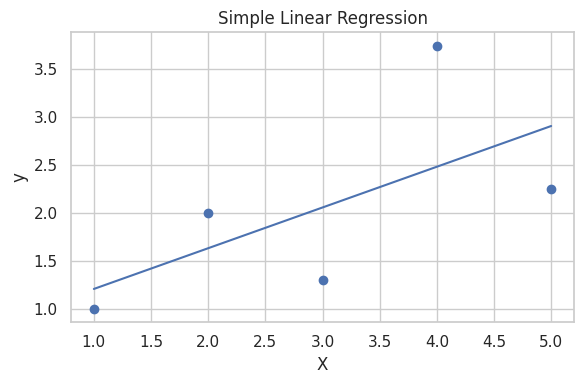

In [93]:
plt.figure(figsize=(6, 4))
plt.scatter(X, y)

x_line = np.linspace(X.min(), X.max(), 100)
plt.plot(x_line, slr.predict(x_line))

plt.xlabel("X")
plt.ylabel("y")
plt.title("Simple Linear Regression")
plt.tight_layout()
plt.show()

### 1.2 Multiple Linear Regression

In [95]:
X = np.array(
    [
        [1,1,1],
        [1,1,2],
        [1,2,2],
        [1,0,1]
    ]
)

Y = np.array([
    3.25,
    6.5,
    3.5,
    5.0
])

In [99]:
class MultipleLinearRegression:
    def __init__(self):
        self.coef_ = None

    def fit(self, X, y):
        xtx = X.T @ X
        xtx_inv = np.linalg.inv(xtx)
        self.coef_ = xtx_inv @ X.T @ y
        return self

    def predict(self, X):
        return X @ self.coef_

In [100]:
mlr = MultipleLinearRegression()
mlr.fit(X, Y)

Y_pred = mlr.predict(X)

print("Coefficients (including intercept term):", mlr.coef_)
print("Predictions:", Y_pred)


Coefficients (including intercept term): [ 2.0625 -2.375   3.25  ]
Predictions: [2.9375 6.1875 3.8125 5.3125]


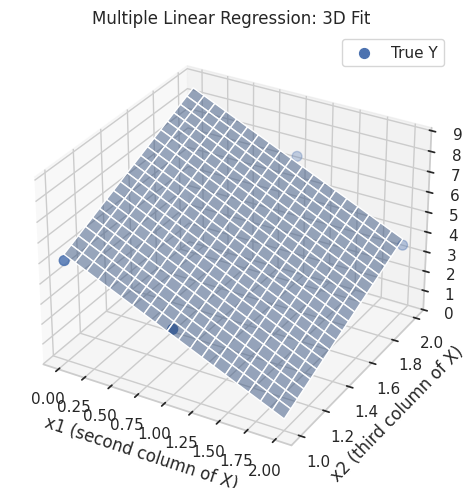

In [101]:
x1 = X[:, 1]
x2 = X[:, 2]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x1, x2, Y, label="True Y", s=50)

x1_grid, x2_grid = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 20),
    np.linspace(x2.min(), x2.max(), 20)
)

X_grid = np.column_stack([
    np.ones(x1_grid.size),
    x1_grid.ravel(),
    x2_grid.ravel()
])

Y_grid = mlr.predict(X_grid).reshape(x1_grid.shape)

ax.plot_surface(x1_grid, x2_grid, Y_grid, alpha=0.5)

ax.set_xlabel("x1 (second column of X)")
ax.set_ylabel("x2 (third column of X)")
ax.set_zlabel("Y")
ax.set_title("Multiple Linear Regression: 3D Fit")
plt.legend()
plt.tight_layout()
plt.show()

### 1.3 Gradient Descent

In [102]:
def gradient_descent(
    starting_point,
    gradient_func,
    learning_rate=0.1,
    max_iter=100,
    tolerance=1e-6,
):

    x = float(starting_point)
    history = [x]

    for _ in range(max_iter):
        diff = lr * gradient_func(x)
        if np.abs(diff) < tolerance:
            break
        else:
            x = x - diff
            history.append(x)

    return history, x


In [103]:
def func(x):
    return x**2 - 4*x + 1

def grad_func(x):
    return 2*x - 4


Optimized result: 1.9999952109514347


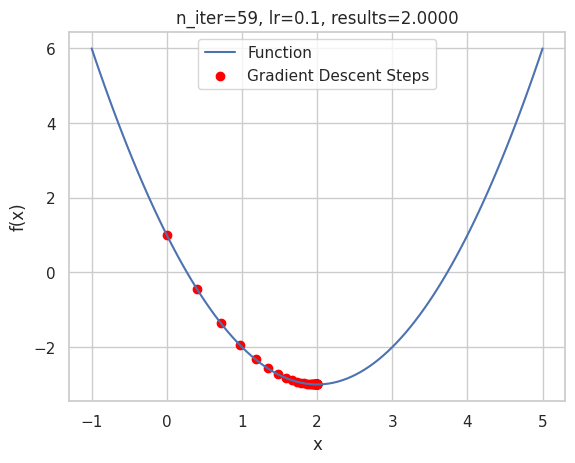

In [106]:
lr = 0.1

history, result = gradient_descent(
    starting_point=0.0,
    gradient_func=grad_func,
    learning_rate=lr,
    max_iter=60,
    tolerance=1e-6
)
print("Optimized result:", result)

history_array = np.array(history)
x_vals = np.linspace(-1, 5, 100)
y_vals = func(x_vals)

plt.plot(x_vals, y_vals, label='Function')
plt.scatter(history_array, func(history_array), color='red', label='Gradient Descent Steps')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'n_iter={len(history)}, lr={lr}, results={result:.4f}')

plt.show()

## 2. Using scikit-learn

### 2.1. Load dataset

- In this lab, we use dataset [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) (id=9).
- We want to predict Miles Per Gallon (MPG) - a measure of a vehicle's fuel efficiency. It shows how many miles a car can travel on one gallon of fuel. A higher MPG means a car is more fuel-efficient, travels further on less fuel, and can result in lower running costs.

In [18]:
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    !pip install ucimlrepo
    from ucimlrepo import fetch_ucirepo

In [19]:

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

In [20]:
auto_mpg.metadata

{'uci_id': 9,
 'name': 'Auto MPG',
 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg',
 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv',
 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption',
 'area': 'Other',
 'tasks': ['Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 398,
 'num_features': 7,
 'feature_types': ['Real', 'Categorical', 'Integer'],
 'demographics': [],
 'target_col': ['mpg'],
 'index_col': ['car_name'],
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1993,
 'last_updated': 'Thu Aug 10 2023',
 'dataset_doi': '10.24432/C5859H',
 'creators': ['R. Quinlan'],
 'intro_paper': None,
 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had 

In [21]:
auto_mpg.variables

,name,role,type,demographic,description,units,missing_values
0,displacement,Feature,Continuous,None,None,None,no
1,mpg,Target,Continuous,None,None,None,no
2,cylinders,Feature,Integer,None,None,None,no
3,horsepower,Feature,Continuous,None,None,None,yes
4,weight,Feature,Continuous,None,None,None,no
5,acceleration,Feature,Continuous,None,None,None,no
6,model_year,Feature,Integer,None,None,None,no
7,origin,Feature,Integer,None,None,None,no
8,car_name,ID,Categorical,None,None,None,no


In [22]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [23]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


### 2.2. EDA

#### General sanity check

In [24]:
# Combine features and target into a single DataFrame for EDA
df = pd.concat([X, y], axis=1)

In [25]:
df.isna().sum()

,0
displacement,0
cylinders,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0
mpg,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   horsepower    392 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model_year    398 non-null    int64  
 6   origin        398 non-null    int64  
 7   mpg           398 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


In [27]:
df.describe()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
count,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,193.425879,5.454774,104.469388,2970.424623,15.568090,76.010050,1.572864,23.514573
std,104.269838,1.701004,38.491160,846.841774,2.757689,3.697627,0.802055,7.815984
min,68.000000,3.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,104.250000,4.000000,75.000000,2223.750000,13.825000,73.000000,1.000000,17.500000
50%,148.500000,4.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,23.000000
75%,262.000000,8.000000,126.000000,3608.000000,17.175000,79.000000,2.000000,29.000000
max,455.000000,8.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [28]:
df.sample(5)

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
174,171.0,6,97.0,2984,14.5,75,1,18.0
40,351.0,8,153.0,4154,13.5,71,1,14.0
209,120.0,4,88.0,3270,21.9,76,2,19.0
149,120.0,4,97.0,2489,15.0,74,3,24.0
122,121.0,4,110.0,2660,14.0,73,2,24.0


In [29]:
df['origin'].unique()

array([1, 3, 2])

In [30]:
# Check cases where 'horsepower' is missing
df[df['horsepower'].isna()]

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
32,98.0,4,NaN,2046,19.0,71,1,25.0
126,200.0,6,NaN,2875,17.0,74,1,21.0
330,85.0,4,NaN,1835,17.3,80,2,40.9
336,140.0,4,NaN,2905,14.3,80,1,23.6
354,100.0,4,NaN,2320,15.8,81,2,34.5
374,151.0,4,NaN,3035,20.5,82,1,23.0


In [31]:
# Fill missing 'horsepower' values with the median
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())
df.isna().sum()

,0
displacement,0
cylinders,0
horsepower,0
weight,0
acceleration,0
model_year,0
origin,0
mpg,0


In [32]:
df.iloc[32,:]

,32
displacement,98.0
cylinders,4.0
horsepower,93.5
weight,2046.0
acceleration,19.0
model_year,71.0
origin,1.0
mpg,25.0


#### Univariate analysis

Study the distribution of each variable individually

array([[<Axes: title={'center': 'displacement'}>,
        <Axes: title={'center': 'horsepower'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'acceleration'}>],
       [<Axes: title={'center': 'mpg'}>, <Axes: >]], dtype=object)

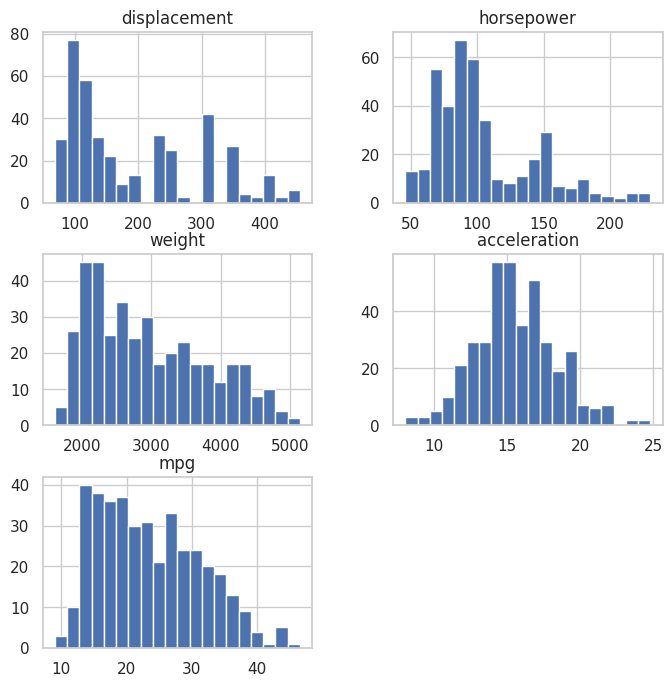

In [33]:
# Check distribution of numerical columns
cat_cols = ['cylinders', 'model_year', 'origin']
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = [col for col in num_cols if col not in cat_cols]

df[num_cols].hist(bins=20, figsize=(8,8))

Unique values in cylinders: [8 4 6 3 5]
Unique values in model_year: [70 71 72 73 74 75 76 77 78 79 80 81 82]
Unique values in origin: [1 3 2]


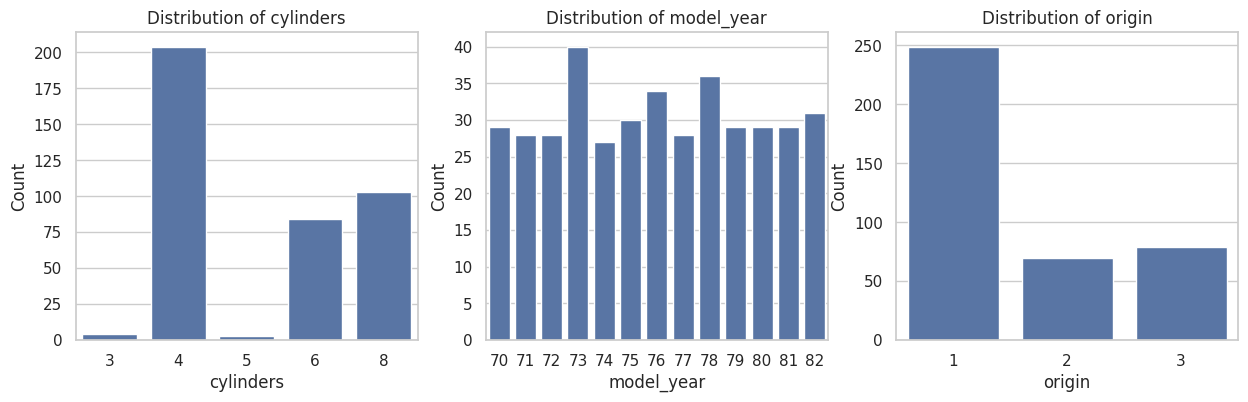

In [34]:
# Check unique values in categorical columns
for col in cat_cols:
    print(f"Unique values in {col}: {df[col].unique()}")

# Check distributin of unque values in categorical columns
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Count')

### 2.4. Multivariate analysis

Explore interactions among multiple features

<Axes: >

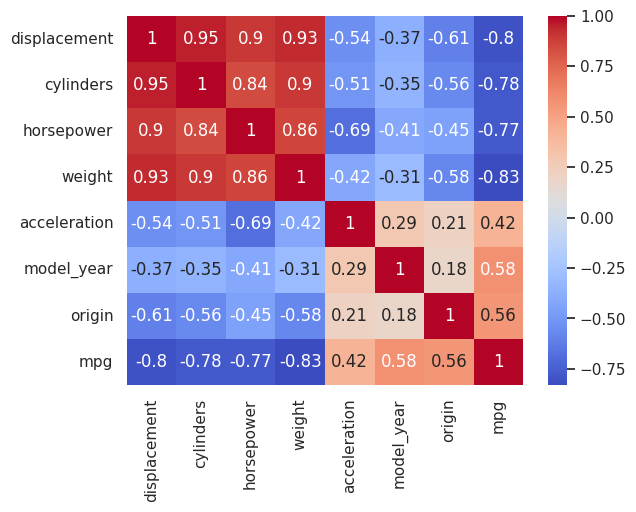

In [35]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

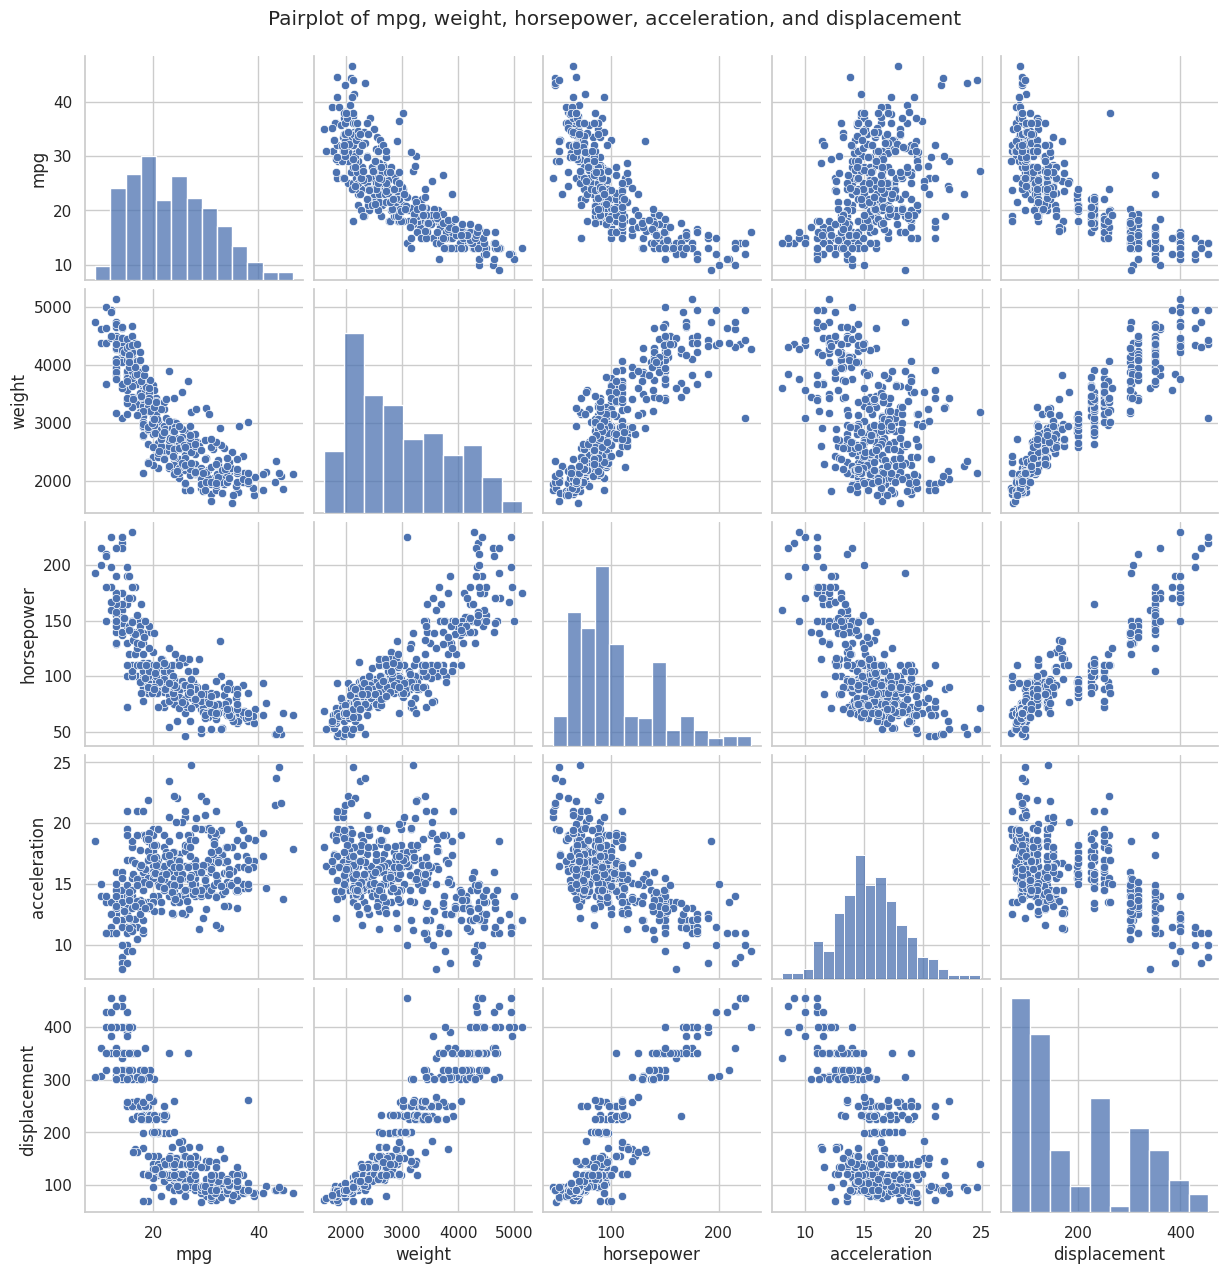

In [36]:
# (a) Pairplot of selected features
cols_pair = ['mpg', 'weight', 'horsepower', 'acceleration', 'displacement']
sns.pairplot(df[cols_pair].dropna(), diag_kind='hist')
plt.suptitle("Pairplot of mpg, weight, horsepower, acceleration, and displacement", y=1.02)
plt.show()

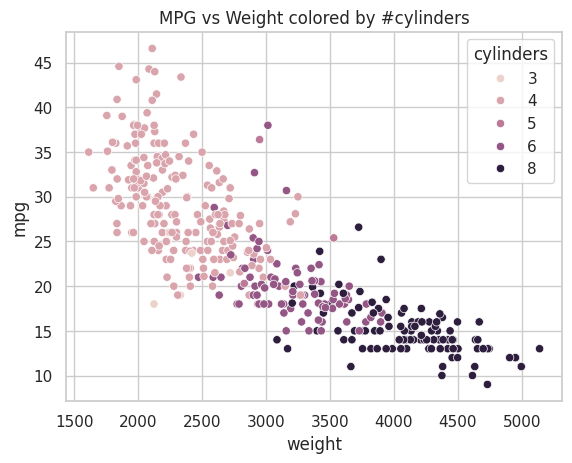

In [37]:
# (b) Scatter: mpg vs weight, colored by cylinders
sns.scatterplot(
    data=df,
    x='weight',
    y='mpg',
    hue='cylinders',
)
plt.title("MPG vs Weight colored by #cylinders")
plt.show()

## 3. Feature engineering

In [82]:
df["log_weight"] = np.log(df["weight"])
df["log_hp"]     = np.log(df["horsepower"])
df["log_disp"]   = np.log(df["displacement"])

In [83]:
feature_cols = [
    'cylinders',
    'log_disp',
    'log_hp',
    'log_weight',
    'acceleration',
    'model_year',
    'origin',
]

X_features = df[feature_cols].values
y_target = df['mpg'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

print("Feature matrix shape:", X_scaled.shape)
print("Target vector shape:", y_target.shape)


Feature matrix shape: (398, 7)
Target vector shape: (398,)


## 4. Model training

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_target,
    test_size=0.2,
    random_state=42,
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 318
Test set size: 80


In [85]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print("Intercept:", lin_reg.intercept_)
print("Coefficients:", lin_reg.coef_)


Intercept: 23.4868930810458
Coefficients: [ 1.19483677 -1.15388766 -1.7062963  -4.17564756 -0.4500956   2.90811852
  0.54398512]


## 5. Evaluatation

In [86]:
y_pred = lin_reg.predict(X_test)
print("First 10 predictions:", y_pred[:10])
print("First 10 true values:", y_test[:10])


First 10 predictions: [34.4632524  29.36963504 20.36302688 16.95774987 13.30029288 26.44223531
 27.32706164  9.70616793 18.34305354 21.42724722]
First 10 true values: [33. 28. 19. 13. 14. 27. 24. 13. 17. 21.]


In [87]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")


MAE:  2.083
MSE:  7.354
RMSE: 2.712
R^2:  0.863
